# 변동성 돌파 개선

## 종목 선정
**대상** : 코스닥 150 레버리지
**기간**: 2021.01.01 ~ 2021.12.31
**매수(long)** : 당일 종가가 5일 이동평균선을 상향돌파
**매도(short)** : 다음날 시가에 매도
**수수료 + 슬리피지** : 0.15%

### data format
```json
{
    "meta": {
        "symbol": "233740",
        "interval": "1h",
        "currency": "KRW",
        "exchange_timezone": "Asia/Seoul",
        "exchange": "KRX",
        "mic_code": "XKRX",
        "type": "ETF"
    },
    "values": [
        {
            "datetime": "2024-04-30 15:00:00",
            "open": "11980.00000",
            "high": "11990.00000",
            "low": "11920.00000",
            "close": "11935.00000",
            "volume": "552927",
            "previous_close": "11975.00000"
        }
    ]
}
```

[Kodex 코스닥150 레버리지](https://www.samsungfund.com/etf/product/view.do?id=2ETF56)

In [53]:
import json
import pandas as pd

with open('time_series_232080_1day.json') as f:
    data = json.load(f)
    
df = pd.DataFrame(data['values'])
df

,datetime,open,high,low,close,volume,previous_close
0,2024-05-24,13615.00000,13810.00000,13560.00000,13675.00000,323852,13810.00000
1,2024-05-23,13855.00000,13945.00000,13755.00000,13810.00000,175844,13850.00000
2,2024-05-22,13925.00000,13925.00000,13825.00000,13850.00000,230908,13840.00000
3,2024-05-21,13865.00000,13875.00000,13720.00000,13840.00000,461955,13780.00000
4,2024-05-20,13830.00000,13900.00000,13695.00000,13780.00000,424677,13795.00000
...,...,...,...,...,...,...,...
3096,2016-01-06,11190.00000,11190.00000,10900.00000,11160.00000,582392,11160.00000
3097,2016-01-06,11190.00000,11190.00000,10900.00000,11160.00000,582392,10965.00000
3098,2016-01-05,10720.00000,11145.00000,10720.00000,10965.00000,1706256,10965.00000
3099,2016-01-05,10720.00000,11145.00000,10720.00000,10965.00000,1706256,10970.00000


## 주가(종가) 추이 보기

날짜별 종가를 시각화하여 주가 추이를 확인한다

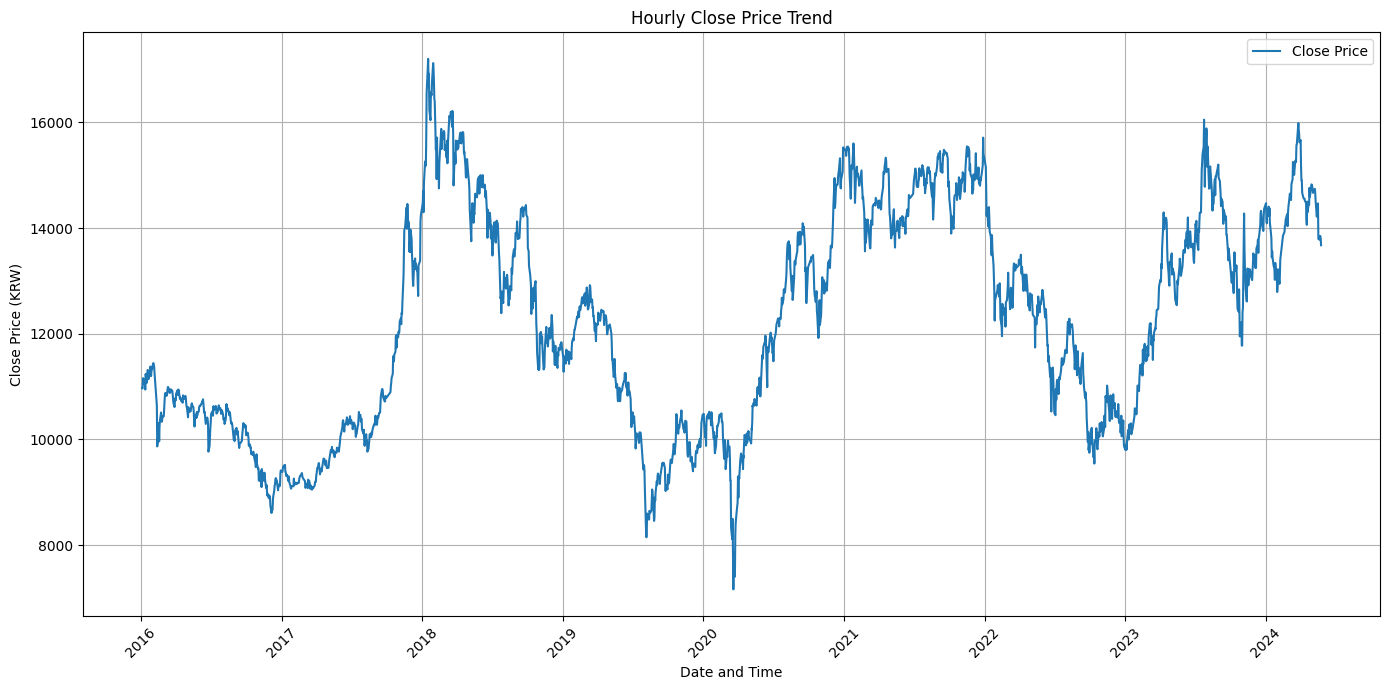

In [54]:
import matplotlib.pyplot as plt

# Convert datetime column to pandas datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

# Sort dataframe by datetime
df = df.sort_values(by='datetime')

# Convert the 'close' column to numeric type
df['close'] = pd.to_numeric(df['close'])

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(df['datetime'], df['close'], label='Close Price')

plt.title('Hourly Close Price Trend')
plt.xlabel('Date and Time')
plt.ylabel('Close Price (KRW)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate datetime labels for better readability
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

## 노이즈 비교

여러 다른 종목들과 **Kodex 코스닥150 레버리지** 의 평균 노이즈를 비교해보자

- [Kodex 코스피](https://www.samsungfund.com/etf/product/view.do?id=2ETF52)
- [S&P 500](https://kr.investing.com/indices/us-spx-500)
- [Bitcoin](https://kr.investing.com/crypto/bitcoin/btc-krw)

### 캔들의 노이즈 구하기

$
\text{노이즈} = 1 - \frac{|\text{시가} - \text{종가}|}{\text{고가} - \text{저가}}
$

> 블로그에서 읽은 내용과 달리 노이즈의 차이가 별로 없다.

> 실제로 코스닥 지수와 코스피 지수의 노이즈값을 평균해보면, 코스닥은 0.42인데 반해, 코스피는 0.5가 넘습니다. 해외 지수를 가지고 테스트해보면 변동성 돌파 전략이 잘 먹히지 않는 종목은 노이즈값이 0.5 이상으로 큰데 비해, 기가막힌 수익 곡선을 보여주는 경우는 노이즈값이 0.4정도를 보여줍니다. 대표적으로 베트남 지수도 코스닥과 유사한 0.4정도입니다. 

출처: https://stock79.tistory.com/entry/실전-투자-전략-52-Noise-ratio를-이용한-변동성-돌파-전략-개선 [systrader79의 왕초보를 위한 주식 투자:티스토리]

In [1]:
import json
import pandas as pd

def get_noise(open, high, low, close):
    try:
        high = pd.to_numeric(high)
        low = pd.to_numeric(low)
        open = pd.to_numeric(open)
        close = pd.to_numeric(close)
        
        if high == low:  # Avoid division by zero
            return 0
        
        return 1 - abs(open - close) / (high - low)
    except Exception as e:
        return 0  # or handle it in a way that suits your needs

# Read JSON files
with open('time_series_233740_1h.json') as f:
    j2ETF52 = json.load(f)  # Kodex 코스닥150 레버리지
    
with open('time_series_233740_1h.json') as f:
    j233740 = json.load(f)  # Kodex 코스피
    
with open('time_series_SPX_1h.json') as f:
    jSPX = json.load(f)  # S&P 500
    
with open('time_series_btckrw_1h.json') as f:
    jBTC = json.load(f)  # Bitcoin

# Create dataframes
df2ETF52 = pd.DataFrame(j2ETF52['values'])
df233740 = pd.DataFrame(j233740['values'])
dfSPX = pd.DataFrame(jSPX['values'])
dfBTC = pd.DataFrame(jBTC['values'])

# Calculate noise
df2ETF52['noise'] = df2ETF52.apply(lambda x: get_noise(x['open'], x['high'], x['low'], x['close']), axis=1)
df233740['noise'] = df233740.apply(lambda x: get_noise(x['open'], x['high'], x['low'], x['close']), axis=1)
dfSPX['noise'] = dfSPX.apply(lambda x: get_noise(x['open'], x['high'], x['low'], x['close']), axis=1)
dfBTC['noise'] = dfBTC.apply(lambda x: get_noise(x['open'], x['high'], x['low'], x['close']), axis=1)

# Calculate average noise
avg_noise_2ETF52 = df2ETF52['noise'].mean()
avg_noise_233740 = df233740['noise'].mean()
avg_noise_SPX = dfSPX['noise'].mean()
avg_noise_BTC = dfBTC['noise'].mean()

print(f'Average noise of Kodex 코스닥150 레버리지: {avg_noise_2ETF52:.2f}')
print(f'Average noise of Kodex 코스피: {avg_noise_233740:.2f}')
print(f'Average noise of S&P 500: {avg_noise_SPX:.2f}')
print(f'Average noise of Bitcoin: {avg_noise_BTC:.2f}')


Average noise of Kodex 코스닥150 레버리지: 0.52
Average noise of Kodex 코스피: 0.52
Average noise of S&P 500: 0.51
Average noise of Bitcoin: 0.52


## 노이즈 비율을 이용한 돌파 전략

기본 변동성 돌파 전략에서 돌파 계수를 고정하지 않고 동적으로 설정한다.

돌파 계수 K 값이 커질 수록 매수 빈도가 낮아지고, 작아질수록 매수 빈도가 높아진다.

노이즈 비율이 작아질수록 추세적이므로 K를 특정 기간동안의 noise ratio의 평균값으로 설정한다.

기간은 임의로 13일로 설정한다.

- 대상 : 코스닥 150 레버리지 
- 기간: 2021-10-12 09:00:00 ~ 2024-04-30 15:00:00 (시간단위)
- 매수 : 가격 > 당일 시가 + 전일 range (전일 고가 - 전일 저가) * 13일 평균 noise ratio 
- 매도 : 다음날 시가에 매도 
- 수수료 + 슬리피지 : 0.15%

In [88]:
import json
import pandas as pd
from pykrx import stock

# df = stock.get_market_ohlcv("20160101", "20240524", "229200", "d")


with open('time_series_btckrw_1h.json') as f:
    data = json.load(f)  # Kodex 코스닥150
    
df = pd.DataFrame(data['values'])
df['datetime'] = pd.to_datetime(df['datetime'])
df['close'] = pd.to_numeric(df['close'])
df.sort_values(by='datetime', inplace=True)

# 단순 보유 수익률 (시작가에서 끝가까지 보유한 수익률)
first_close = df['close'].iloc[0]
last_close = df['close'].iloc[-1]

simple_return = (last_close - first_close) / first_close
print(f"시작가: {first_close:.2f}")
print(f"끝가: {last_close:.2f}")
print(f"Simple Return: {simple_return:.2f}")


# CAGR = (L/F)^(1/Y) - 1
# F = 처음 값, L = 마지막 값, Y = 처음 값과 마지막 값 사이의 연(year) 수
years = (df['datetime'].iloc[-1] - df['datetime'].iloc[0]).days / 365

cagr = (last_close / first_close) ** (1 / years) - 1
print(f"CAGR: {cagr:.2f}")

시작가: 37874000.00
끝가: 85525000.00
Simple Return: 1.26
CAGR: 3.18


           종목명     매도거래량     매수거래량  순매수거래량        매도거래대금        매수거래대금  \
티커                                                                       
060310      3S   1586291   1586291       0    3524647100    3524647100   
054620  APS홀딩스    989024    989024       0    6939092530    6939092530   
265520   AP시스템   1709902   1709902       0   43145888750   43145888750   
211270    AP위성  18408001  18408001       0  181381487900  181381487900   
035760  CJ ENM   1193021   1193021       0  193380189900  193380189900   

        순매수거래대금  
티커               
060310        0  
054620        0  
265520        0  
211270        0  
035760        0  
              시가    고가    저가    종가     거래량        등락률
날짜                                                   
2014-05-26  4600  4700  4575  4600  154645   0.000000
2014-05-27  4545  4685  4545  4615  116253   0.326087
2014-05-28  4640  4700  4625  4670  116953   1.191766
2014-05-29  4705  4710  4630  4645   83434  -0.535332
2014-05-30  4645  4685  4130  4

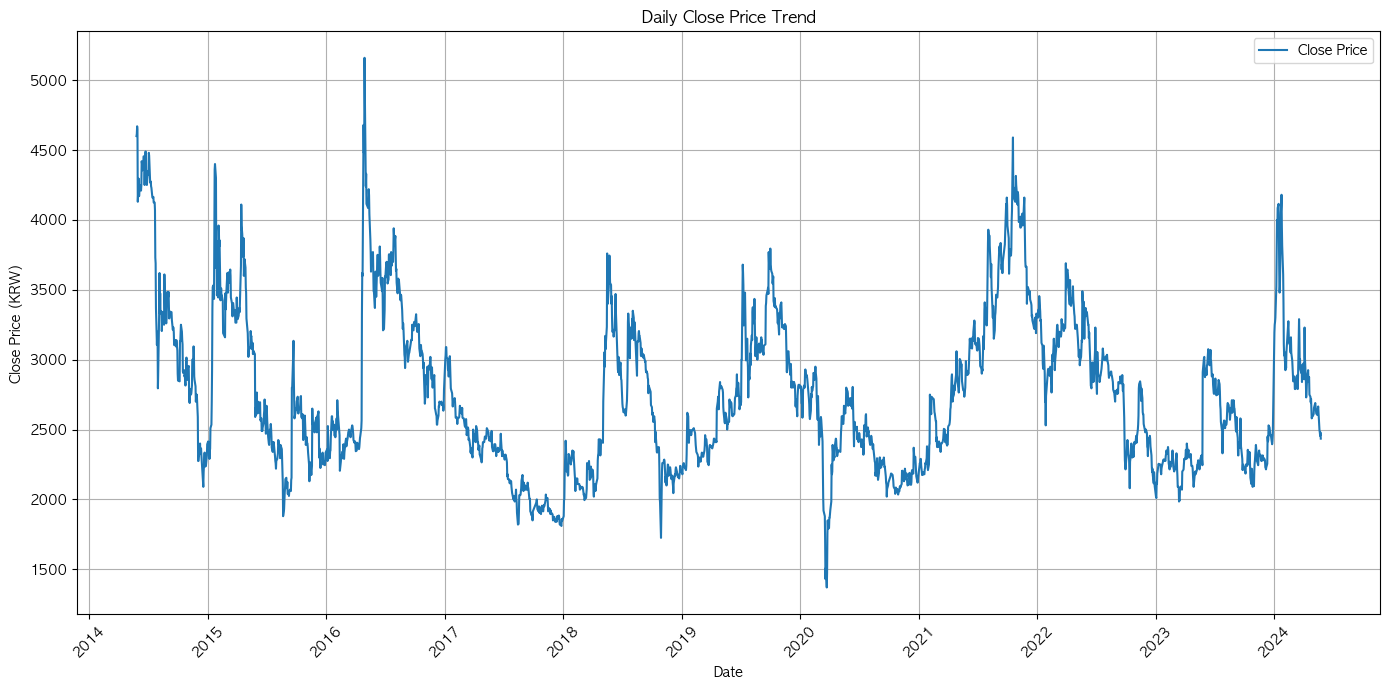

In [2]:
import pandas as pd
from pykrx import stock

df = stock.get_market_net_purchases_of_equities("20210115", "20210122", "KOSDAQ", "전체")
print(df.head())

# 첫번째 티커 추출
df = stock.get_market_ohlcv("20140524", "20240524", df.index[0], "d")

print(df.head())

# 날짜별 종가를 시각화하여 주가 추이를 확인한다
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['종가'], label='Close Price')

plt.title('Daily Close Price Trend')
plt.xlabel('Date')
plt.ylabel('Close Price (KRW)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate datetime labels for better readability
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()


## 수익률
- 단순 보유 수익률 (시작가에서 끝가까지 보유한 수익률)

In [101]:
first_close = df['종가'].iloc[0]
last_close = df['종가'].iloc[-1]

simple_return = (last_close - first_close) / first_close
print(f"시작가: {first_close:.2f}")
print(f"끝가: {last_close:.2f}")
print(f"Simple Return: {simple_return:.2f}")

시작가: 4600.00
끝가: 2435.00
Simple Return: -0.47


In [12]:
# 노이즈 비율을 이용한 돌파 전략

def get_noise(open, high, low, close):
    try:
        high = pd.to_numeric(high)
        low = pd.to_numeric(low)
        open = pd.to_numeric(open)
        close = pd.to_numeric(close)
        
        if high == low:  # Avoid division by zero
            return 0
        
        return 1 - abs(open - close) / (high - low)
    except Exception as e:
        return 0  # or handle it in a way that suits your needs

# 13일 평균 노이즈 비율 구하기    
df['noise'] = df.apply(lambda x: get_noise(x['시가'], x['고가'], x['저가'], x['종가']), axis=1)
df['noise_mean'] = df['noise'].rolling(window=13).mean()

# 변동성 돌파 전략
# 매수조건 : 가격 > 당일 시가 + 전일 range (전일 고가 - 전일 저가) * 13일 평균 noise ratio 
# 매도 : 다음날 시가에 매도

# 날짜기준 정렬
df = df.sort_values(by='날짜')

df['range'] = df['고가'] - df['저가']
df['buy'] = df['시가'] + df['range'].shift(1) * df['noise_mean']
df['sell'] = df['시가'].shift(-1)
# 매수 여부
df['buy_signal'] = df['종가'] > df['buy']
# 매도 여부 (매수한 다음날)
df['sell_signal'] = df['buy_signal'].shift(1)

# 수익률 
df['return'] = df['sell'] / df['buy'] - 1
df['return'] = df['return'].where(df['buy_signal'] == True)

# 복리 수익률 (매매후 수익률의 곱) 
df['cum_return'] = (1 + df['return']).cumprod()

# cagr = (L/F)^(1/Y) - 1
years = 10
cagr = (df['cum_return'].dropna().iloc[-1]) ** (1 / years) - 1
print(f"노이즈 반영 CAGR: {cagr:.2f}")

# mdd = (H - L) / H
max_return = df['cum_return'].cummax()
mdd = (df['cum_return'] - max_return) / max_return
print(f"노이즈 반영 MDD: {mdd.min():.2f}")

# 노이즈 미반영
df['not_noise_buy'] = df['시가'] + df['range'].shift(1) * 0.1
df['not_noise_buy_signal'] = df['종가'] > df['not_noise_buy']
df['not_noise_sell_signal'] = df['not_noise_buy_signal'].shift(1)
df['not_noise_return'] = df['sell'] / df['not_noise_buy'] - 1
df['not_noise_return'] = df['not_noise_return'].where(df['not_noise_buy_signal'] == True)
df['not_noise_cum_return'] = (1 + df['not_noise_return']).cumprod()

years = 10
cagr = (df['not_noise_cum_return'].dropna().iloc[-1]) ** (1 / years) - 1
print(f"노이즈 미반영 CAGR: {cagr:.2f}")

max_return = df['not_noise_cum_return'].cummax()
mdd = (df['not_noise_cum_return'] - max_return) / max_return
print(f"노이즈 미반영 MDD: {mdd.min():.2f}")

df


노이즈 반영 CAGR: 1.92
노이즈 반영 MDD: -0.03
노이즈 미반영 CAGR: 9.36
노이즈 미반영 MDD: -0.04


,시가,고가,저가,종가,거래량,등락률,noise,noise_mean,range,buy,sell,buy_signal,sell_signal,return,cum_return,not_noise_buy,not_noise_buy_signal,not_noise_sell_signal,not_noise_return,not_noise_cum_return
날짜,,,,,,,,,,,,,,,,,,,,
2014-05-26,4600,4700,4575,4600,154645,0.000000,1.000000,NaN,125,NaN,4545.0,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
2014-05-27,4545,4685,4545,4615,116253,0.326087,0.500000,NaN,140,NaN,4640.0,False,False,NaN,NaN,4557.5,True,False,0.018102,1.018102e+00
2014-05-28,4640,4700,4625,4670,116953,1.191766,0.600000,NaN,75,NaN,4705.0,False,False,NaN,NaN,4654.0,True,True,0.010958,1.029259e+00
2014-05-29,4705,4710,4630,4645,83434,-0.535332,0.250000,NaN,80,NaN,4645.0,False,False,NaN,NaN,4712.5,False,True,NaN,NaN
2014-05-30,4645,4685,4130,4130,223140,-11.087191,0.072072,NaN,555,NaN,4100.0,False,False,NaN,NaN,4653.0,False,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-20,2620,2625,2490,2495,782528,-4.770992,0.074074,0.591983,135,2664.398760,2520.0,False,False,NaN,NaN,2627.5,False,False,NaN,NaN
2024-05-21,2520,2520,2450,2480,532054,-0.601202,0.428571,0.567258,70,2596.579856,2480.0,False,False,NaN,NaN,2533.5,False,False,NaN,NaN
2024-05-22,2480,2500,2450,2455,417825,-1.008065,0.500000,0.552465,50,2518.672570,2455.0,False,False,NaN,NaN,2487.0,False,False,NaN,NaN


In [13]:
# 시각화

plt.figure(figsize=(14, 7))
plt.plot(df['날짜'], df['cum_return'], label='Cumulative Return (Noise)')
plt.plot(df['날짜'], df['not_noise_cum_return'], label='Cumulative Return (Not Noise)')
plt.title('Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate datetime labels for better readability
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

KeyError: '날짜'

<Figure size 1400x700 with 0 Axes>